In [ ]:
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from os import listdir
from os.path import isdir
from keras_facenet import FaceNet
from matplotlib import pyplot as plt
from numpy import savez_compressed, asarray, load, expand_dims
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from random import choice

In [56]:
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	if len(results) > 0:
		# Extract the bounding box of the first face
		x1, y1, width, height = results[0]['box']
		x1, y1 = abs(x1), abs(y1)
		x2, y2 = x1 + width, y1 + height
		# extract the face
		face = pixels[y1:y2, x1:x2]
		# resize pixels to the model size
		image = Image.fromarray(face)
		image = image.resize(required_size)
		face_array = asarray(image)
		return face_array
	else:
		return None

In [57]:
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)

		if face is None:
			continue

		# store
		faces.append(face)
	return faces

In [58]:
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

In [ ]:
# load train dataset
trainX, trainy = load_dataset('Minggu 12/dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('Minggu 12/dataset/val/')
# save arrays to one file in compressed format
savez_compressed('Minggu 12/data.npz', trainX, trainy, testX, testy)

>loaded 79 examples for class: Jennifer Lawrence


2024-11-16 20:42:31.426309: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


>loaded 78 examples for class: Nicole Kidman
>loaded 79 examples for class: Angelina Jolie
>loaded 78 examples for class: Johnny Depp
>loaded 79 examples for class: Denzel Washington
>loaded 80 examples for class: Tom Cruise
>loaded 79 examples for class: Sandra Bullock
>loaded 80 examples for class: Leonardo DiCaprio
>loaded 80 examples for class: Megan Fox
>loaded 160 examples for class: Scarlett Johansson
>loaded 76 examples for class: Kate Winslet
>loaded 79 examples for class: Natalie Portman
>loaded 79 examples for class: Brad Pitt
>loaded 78 examples for class: Tom Hanks
>loaded 77 examples for class: Will Smith
>loaded 80 examples for class: Hugh Jackman
>loaded 77 examples for class: Robert Downey Jr
(1418, 224, 224, 3) (1418,)
>loaded 20 examples for class: Jennifer Lawrence
>loaded 20 examples for class: Nicole Kidman
>loaded 20 examples for class: Angelina Jolie
>loaded 19 examples for class: Johnny Depp
>loaded 19 examples for class: Denzel Washington
>loaded 20 examples f

2024-11-16 20:53:19.611388: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


>loaded 19 examples for class: Brad Pitt
>loaded 20 examples for class: Tom Hanks
>loaded 19 examples for class: Will Smith
>loaded 20 examples for class: Hugh Jackman
>loaded 20 examples for class: Robert Downey Jr


In [ ]:
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

In [64]:
# load the face dataset
data = load('Minggu 12/data.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (1418, 224, 224, 3) (1418,) (354, 224, 224, 3) (354,)


In [69]:
# load the facenet model
model = FaceNet()
print('Loaded Model')

Loaded Model


In [71]:
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model.model, face_pixels)
	newTrainX.append(embedding)

newTrainX = asarray(newTrainX)
print(newTrainX.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [72]:
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model.model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [74]:
# save arrays to one file in compressed format
savez_compressed('Minggu 12/data-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

In [76]:
# load dataset
data = load('Minggu 12/data-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=1418, test=354


In [77]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

In [78]:
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [79]:
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

SVC(kernel='linear', probability=True)

In [80]:
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)

In [81]:
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=97.814, test=98.870


In [82]:
# load faces
data = load('Minggu 12/data.npz')
testX_faces = data['arr_2']

In [83]:
# load face embeddings
data = load('Minggu 12/data-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

In [84]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

In [85]:
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [86]:
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

SVC(kernel='linear', probability=True)

In [89]:
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

In [90]:
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

In [91]:
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

Predicted: Angelina Jolie (93.970)
Expected: Angelina Jolie


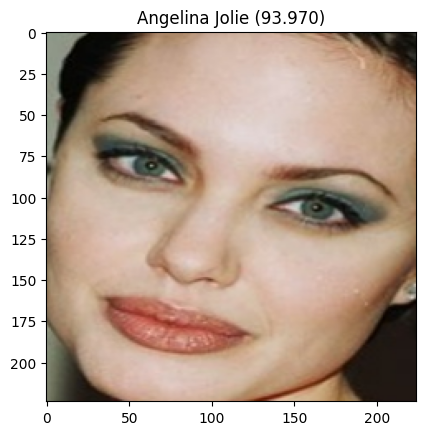

In [92]:
# plot for fun
plt.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()